In [1]:
import scanpy as sc 
import pandas as pd 
import numpy as np 
import anndata as ad 
import scvi

In [2]:
# We first make a scanpy object with the counts we have 
# then we use the scanpy to create a DataLoader
# 
counts = pd.read_csv("../data/integrated_counts/counts_expm1_Feb24.csv", index_col = 0)
meta = pd.read_csv("../data/integrated_counts/meta_data_Feb24.csv", index_col = 0)

counts = counts.T

#scale counts by 10 to increase dynamic range of lowly expressed genes 
# in theory it should not have by contrary effect since we are normamlizing by library size 
counts = counts.div(1/20)
counts = counts.round(0)


meta['total_counts'] = np.sum(counts.values, axis = 1)
meta['cell_ontology_class'] = meta['cell_ontology_class'].str.lower() # make cell type lower case to match across datasets


counts.shape, meta.shape

((1206, 11675), (1206, 10))

In [3]:
meta.head() 

,Tissue_old,cell_ontology_class,age,dataset,cell_id,seurat_clusters,Cell_class,Tissue,total_counts,data_batch
1_E6.5_8.5_Chan,epiblast,epiblast,E6.5,E6.5_8.5_Chan,1_E6.5_8.5_Chan,6,Epiblast,epiblast,168846.0,E6.5_8.5_Chan
2_E6.5_8.5_Chan,xecto,ectoderm early 2,E6.5,E6.5_8.5_Chan,2_E6.5_8.5_Chan,6,Ectoderm,ectoderm,168134.0,E6.5_8.5_Chan
3_E6.5_8.5_Chan,epiblast,epiblast,E6.5,E6.5_8.5_Chan,3_E6.5_8.5_Chan,6,Epiblast,epiblast,162657.0,E6.5_8.5_Chan
4_E6.5_8.5_Chan,epiblast,epiblast,E6.5,E6.5_8.5_Chan,4_E6.5_8.5_Chan,6,Epiblast,epiblast,170598.0,E6.5_8.5_Chan
5_E6.5_8.5_Chan,xecto,extraembryonic ectoderm 1,E6.5,E6.5_8.5_Chan,5_E6.5_8.5_Chan,17,Ex_ectoderm,xecto,173092.0,E6.5_8.5_Chan


In [69]:
counts.loc[['128_E6.5_8.5_Chan','163_E6.5_8.5_Chan','177_E6.5_8.5_Chan'],genes_pathway]

,Wnt10a,Wnt10b,Wnt11,Wnt16,Wnt2,Wnt2b,Wnt3,Wnt3a,Wnt4,Wnt5a,Wnt5b,Wnt6,Wnt7a,Wnt7b,Wnt9a
128_E6.5_8.5_Chan,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,1.0,0.0,0.0,0.0
163_E6.5_8.5_Chan,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,1.0,6.0,2.0,0.0,0.0,0.0,0.0
177_E6.5_8.5_Chan,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0


In [7]:
#normalize
# create the adata object from the count matrix 
adata = ad.AnnData(X = counts, obs = meta)
adata.obs.reset_index(inplace = True)


In [27]:
scvi.data.setup_anndata(adata, 
                        batch_key = 'data_batch' 
                     )

INFO     Using batches from adata.obs["data_batch"]                                          
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 1206 cells, 11675 vars, 7 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [28]:
#'gene-batch' - dispersion can differ between different batches
# 'gene' - dispersion parameter of NB is constant per gene across cells
vae = scvi.model.SCVI(
    adata, 
    gene_likelihood = 'zinb',
    n_hidden = 128, # default 128 
    n_latent = 10, #default 10 
    n_layers = 1, #default 1
    dispersion = 'gene-batch')

In [29]:
vae.train(
    #n_epochs = 1, 
    frequency=1,
    train_size = 0.7,
    lr = 1e-3, 
    #n_epochs_kl_warmup=None,
    #n_iter_kl_warmup=128*5000/400, # Based on documentation at https://www.scvi-tools.org/en/stable/api/reference/scvi.core.trainers.UnsupervisedTrainer.html
    seed=0
)


INFO     Training for 400 epochs                                                             
INFO     KL warmup for 400 epochs                                                            
Training...: 100%|███████████████████████████████████████████████████████████████████| 400/400 [01:23<00:00,  4.78it/s]
INFO     Training time:  44 s. / 400 epochs                                                  


## Loading the model (if already saved)

In [8]:
vae = scvi.model.SCVI.load('../data/scvi/model_integrated_Feb28.h5/', adata, use_cuda = True)

INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 1206 cells, 11675 vars, 7 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


In [9]:
# latent representation 
normalized_gene_expression = vae.get_normalized_expression(library_size=1e4)

In [216]:
normalized_gene_expression.to_csv('../data/scvi/normalized_counts_scvi_Feb28.csv')

In [10]:
genes_pathway = ['Bmpr1a', 'Acvrl1','Acvr1', 'Bmpr1b','Acvr2b', 'Bmpr2', 'Acvr2a']
normalized_gene_expression[genes_pathway]

,Bmpr1a,Acvrl1,Acvr1,Bmpr1b,Acvr2b,Bmpr2,Acvr2a
0,0.392061,0.006119,0.016929,0.005070,0.784572,0.052883,0.059207
1,0.170433,0.004456,0.003550,0.001281,0.298868,0.016531,0.026997
2,0.326860,0.004035,0.011919,0.005049,0.821347,0.047493,0.053213
3,0.331011,0.003875,0.010535,0.004085,0.725928,0.038719,0.047290
4,0.240437,0.016549,0.010103,0.002153,0.312433,0.053708,0.052976
...,...,...,...,...,...,...,...
1201,0.017472,0.045434,0.007411,0.001433,0.010845,0.010066,0.019015
1202,0.078499,0.002126,0.024237,0.005163,0.008959,0.011434,0.055581
1203,0.227825,0.093141,0.074595,0.009041,0.116865,0.084493,0.136806
1204,0.390003,0.146338,0.029946,0.043761,0.050070,0.054390,0.120408


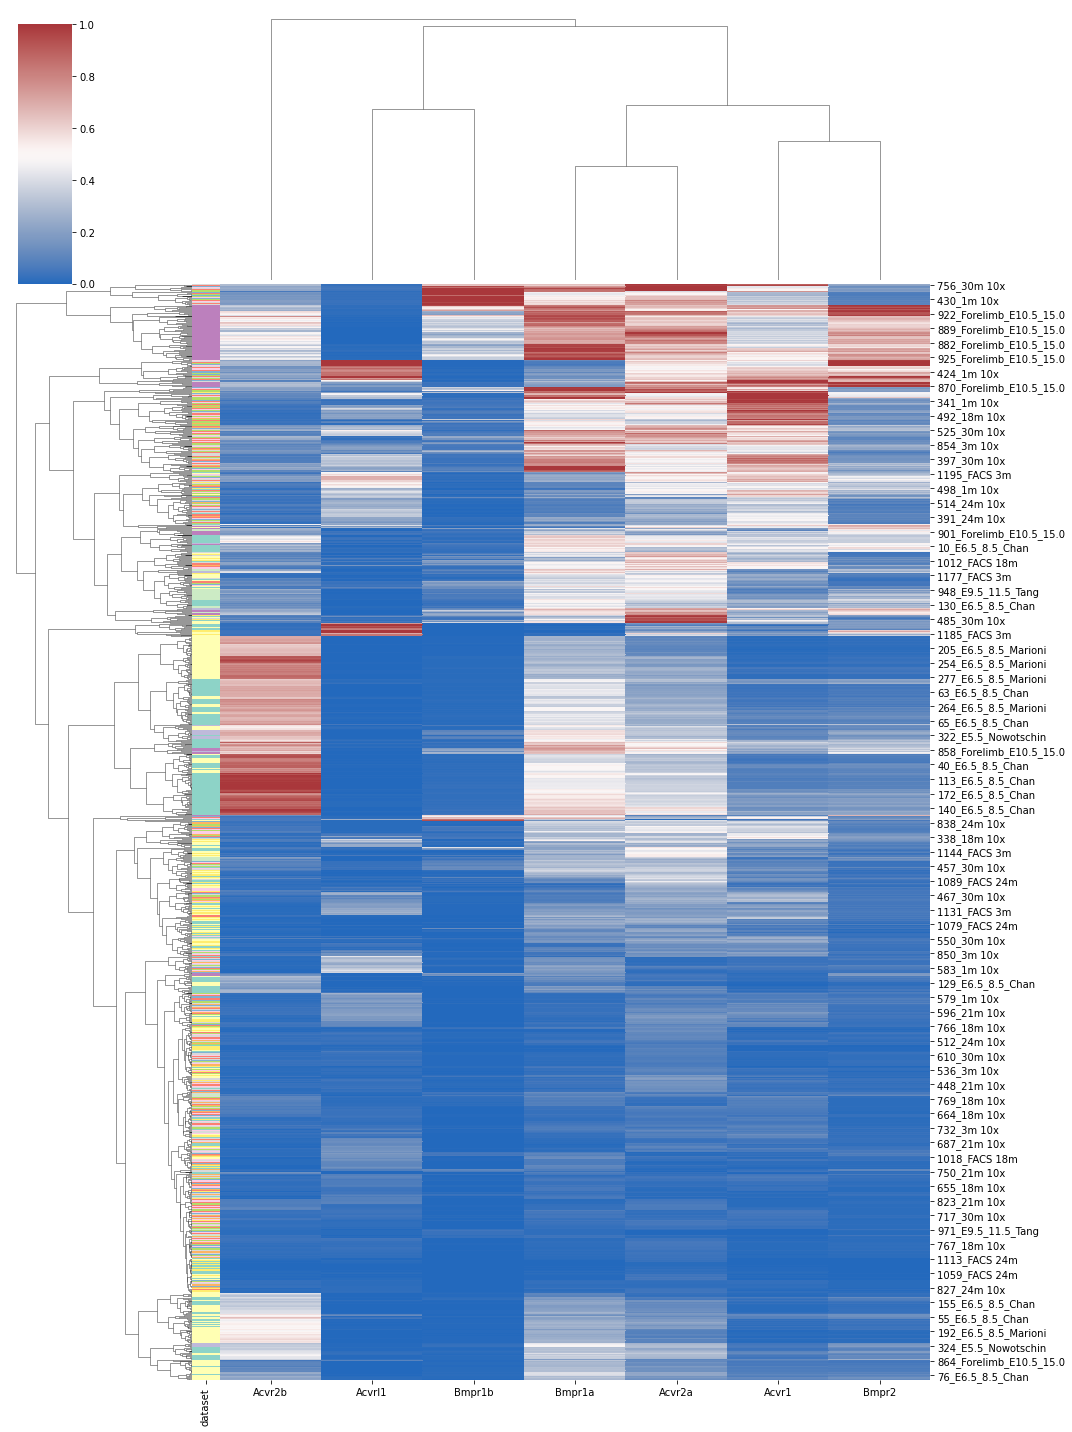

In [12]:
import seaborn as sns 
from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler()

x = normalized_gene_expression[genes_pathway]

x = np.log1p(x.values)

scaled_pathway = scaler.fit_transform(x)

annotatedHeatmap(x, gene_list = genes_pathway, ann_var ='dataset')

In [11]:
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
def annotatedHeatmap(counts_receptors = [], gene_list = [], ann_var ='dataset', dist_metric = 'euclidean'):
    # For cosine distance we can't have rows with only zero values 
    # so we set an extremely low min value 
    scaler =MinMaxScaler(feature_range= (0, 1)) 
    # Corrected counts after batch correction 
    #counts_receptors = corr_data[:,bmp_receptors].X
    # we are normalizing by a quantile instead of the max to buffer the outliers
    quant_limit = np.quantile(counts_receptors, 0.99,0)
    clipped_counts = np.clip(counts_receptors,a_min = 0, a_max = quant_limit)

    # Color palette based on dataset 
    #ann_var = 'dataset'
    profile_pal = sns.color_palette('Set3', len(meta[ann_var].unique() ))
    profile_lut = dict(zip(meta[ann_var].unique() , profile_pal))
    profile_colors = pd.Series( meta[ann_var].map(profile_lut))

    receptor_data = pd.DataFrame(clipped_counts, columns = gene_list)
    scaled_data = scaler.fit_transform(receptor_data.values)
    scaled_df = pd.DataFrame(scaled_data, columns = gene_list, index = meta.index)
    sns.clustermap(scaled_df, cmap = 'vlag', 
                   method ='complete', metric= dist_metric,
                   row_colors = profile_colors, 
                   rasterized = True, figsize = (15,20))

## Plot and inspect individual profiles

In [62]:
import matplotlib.pyplot as plt
# make barchart using catplot 
# from scvi normalized expression scaled by min.max 
# style: https://www.codecademy.com/articles/seaborn-design-i
def cell_type_barplot(scaled_tidy = [], this_cell_type = [], pathway =''):
    sns.set_style("whitegrid",{"xtick.major.size": 12, "ytick.major.size": 12})
    sns.set_context("talk")
    
    cell_type = scaled_tidy[scaled_tidy.cell_type == this_cell_type]
    chart = sns.catplot(data = cell_type, x = 'gene', y ='expression',
                        hue ='cell_id', kind ='bar', legend =True)


    chart.set_xticklabels(rotation=65, horizontalalignment='right')
    chart.fig.suptitle(this_cell_type)
     
    plt.savefig(f'../plots/scvi/{pathway}_{this_cell_type}.png',dpi=300, bbox_inches="tight")
    
# make tidy data frame for a specific pathway 
# allows to use seaborn directly 
# normalized counts from scvi scaled by min.max 
def make_tidy_pathway(normalized_gene_expression, genes_pathway):

    scaler = MinMaxScaler()

    x = normalized_gene_expression[genes_pathway] # relative counts to library size 
    counts_receptors = np.log1p(x.values) # log to make it compatible with other pipelines 

    #saturate data to the 0.99 quantile to reduce the effect of outliers 
    quant_limit = np.quantile(counts_receptors, 0.99,0)
    clipped_counts = np.clip(counts_receptors,a_min = 0, a_max = quant_limit)
    
    scaled_pathway = scaler.fit_transform(clipped_counts)
    scaled_df = pd.DataFrame(scaled_pathway, columns = genes_pathway, index = meta.index)

    scaled_df['cell_type']  =  meta['age'] + ' '+ meta['cell_ontology_class']+ ' ' + meta['Tissue']
    scaled_df['cell_id'] = meta['cell_id']

    scaled_tidy = pd.melt(scaled_df, id_vars = ['cell_type','cell_id'], 
                          value_vars = genes_pathway, var_name ='gene',value_name = 'expression')
    return(scaled_tidy)


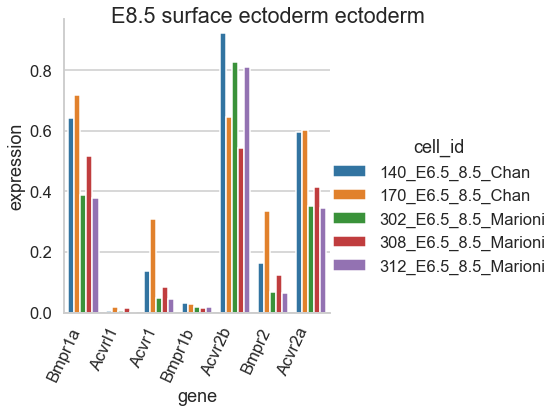

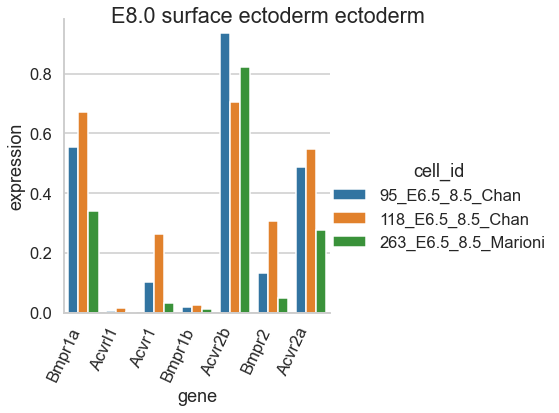

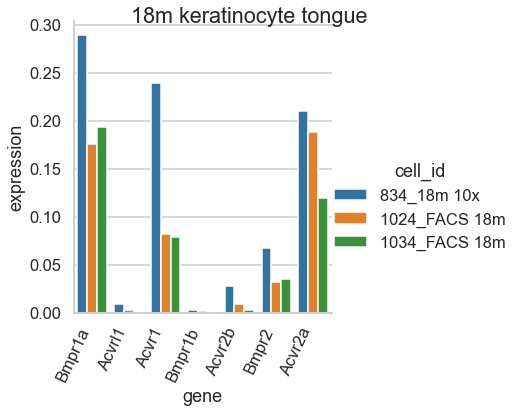

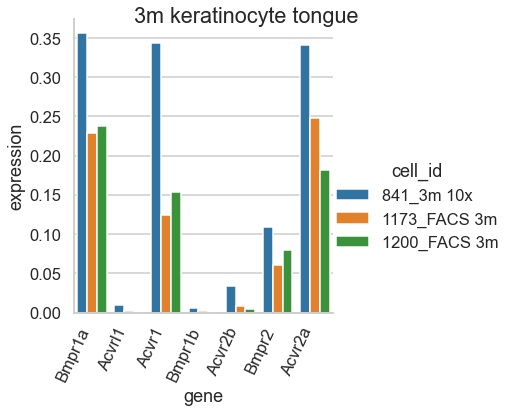

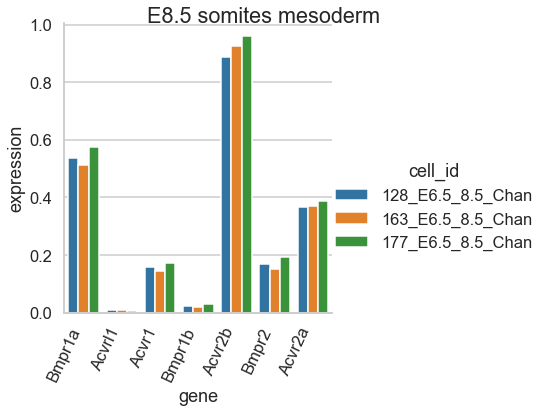

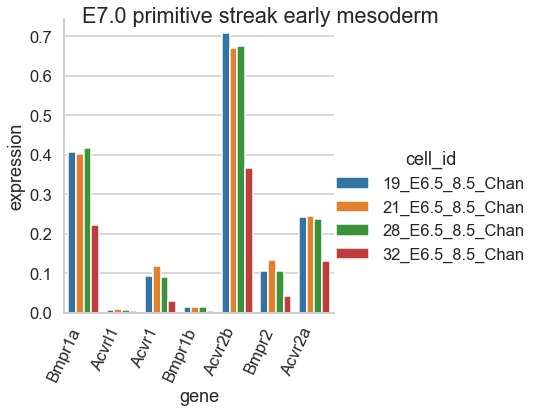

In [63]:
# Make plots for all selected cell types and save 

which_cell_types =["E8.5 surface ectoderm ectoderm","E8.0 surface ectoderm ectoderm",
                   "18m keratinocyte tongue","3m keratinocyte tongue",
                   "E8.5 somites mesoderm","E7.0 primitive streak early mesoderm"]

genes_pathway = ['Bmpr1a', 'Acvrl1','Acvr1', 'Bmpr1b','Acvr2b', 'Bmpr2', 'Acvr2a']

scaled_tidy  = make_tidy_pathway(normalized_gene_expression, genes_pathway)
for cell_type in which_cell_types:
    cell_type_barplot(scaled_tidy, this_cell_type = cell_type, pathway = 'Bmp')

In [44]:
vae.save("../data/scvi/model_integrated_Feb28.h5")

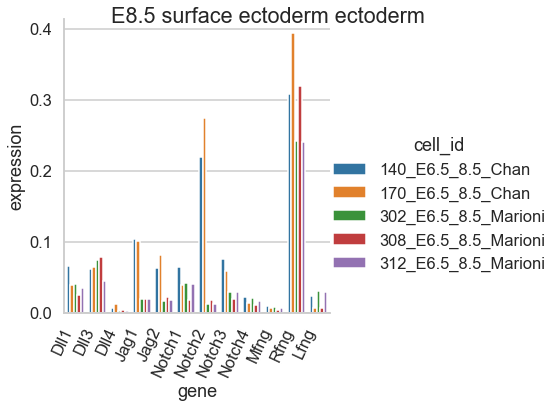

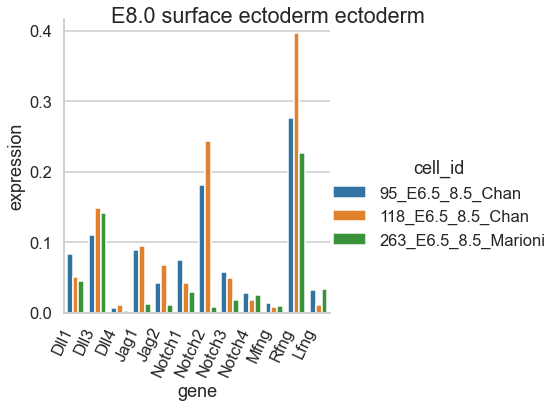

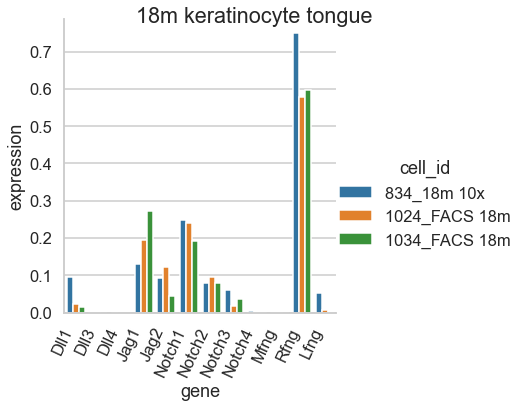

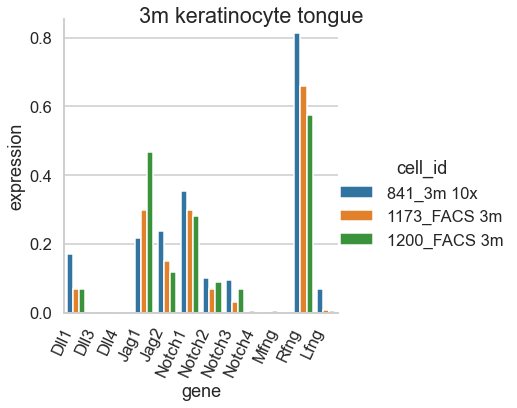

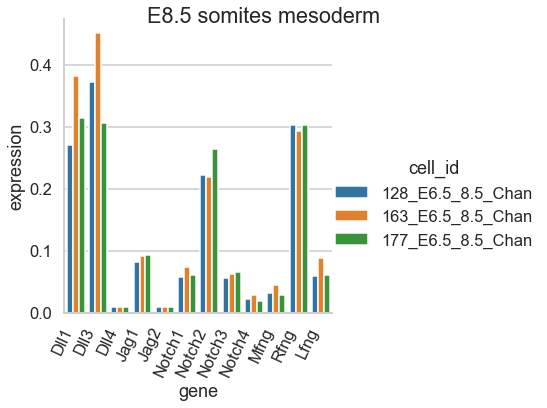

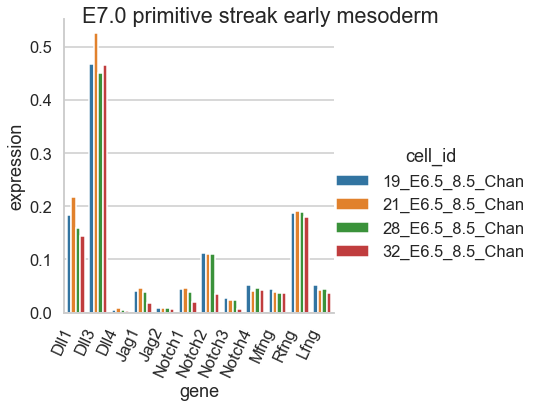

In [29]:
# Notch 

genes_pathway = ["Dll1" ,  "Dll3"  , "Dll4" ,  "Jag1"   ,"Jag2"  , "Notch1", "Notch2", "Notch3" ,"Notch4","Mfng"  , "Rfng"  , "Lfng"] 

scaled_tidy = make_tidy_pathway(normalized_gene_expression, genes_pathway)

for cell_type in which_cell_types:
    cell_type_barplot(scaled_tidy, this_cell_type =cell_type,pathway ='Notch')

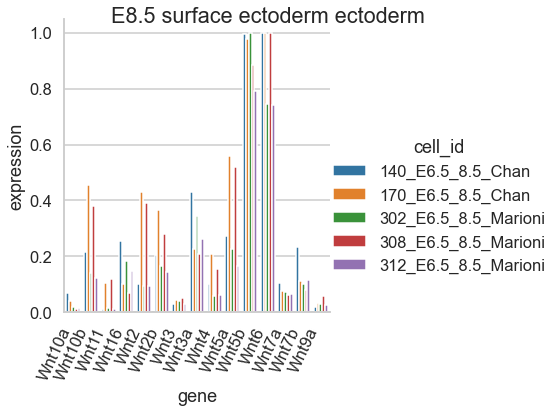

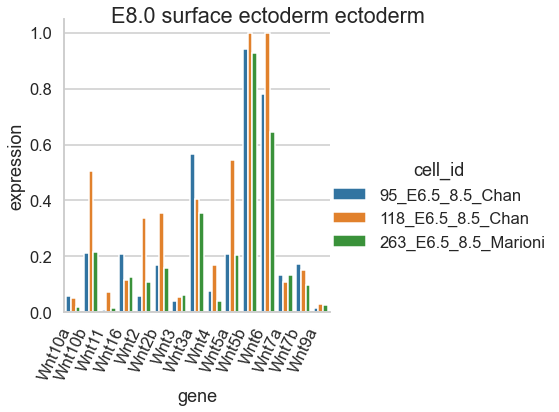

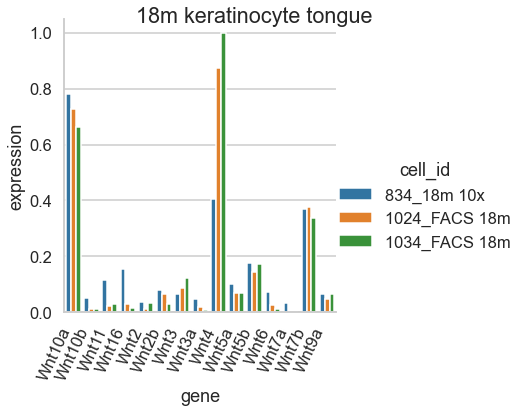

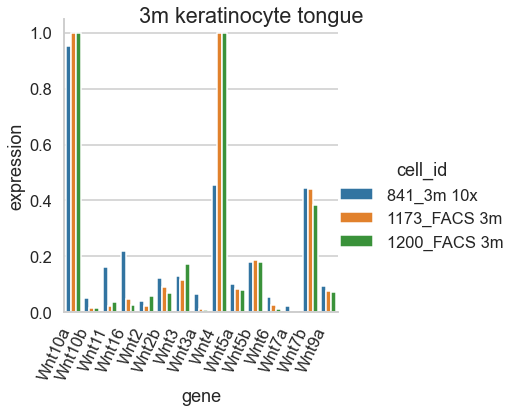

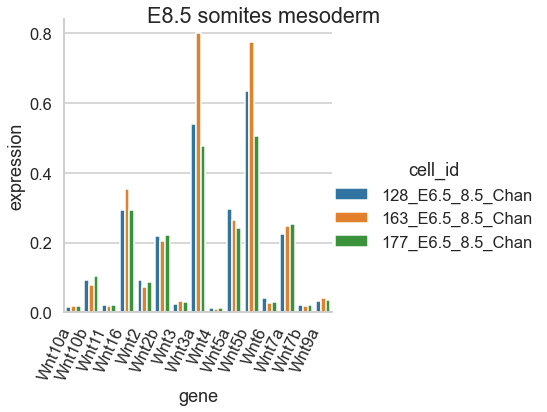

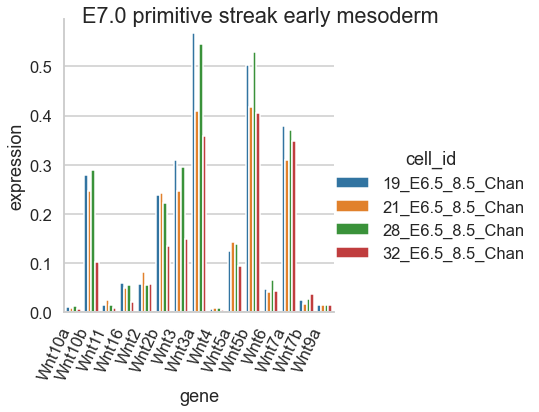

In [64]:
# Wnt ligans 
genes_pathway = ["Wnt10a" ,"Wnt10b", "Wnt11" , "Wnt16" , "Wnt2"  , "Wnt2b" , "Wnt3"   ,
                 "Wnt3a" , "Wnt4",   "Wnt5a"  ,"Wnt5b",  "Wnt6"  ,
                "Wnt7a" , "Wnt7b"  ,"Wnt9a" ]

scaled_tidy = make_tidy_pathway(normalized_gene_expression, genes_pathway)

for cell_type in which_cell_types:
    cell_type_barplot(scaled_tidy, this_cell_type =cell_type,pathway ='Wnt_l')


## Plot all profiles and average by cell type

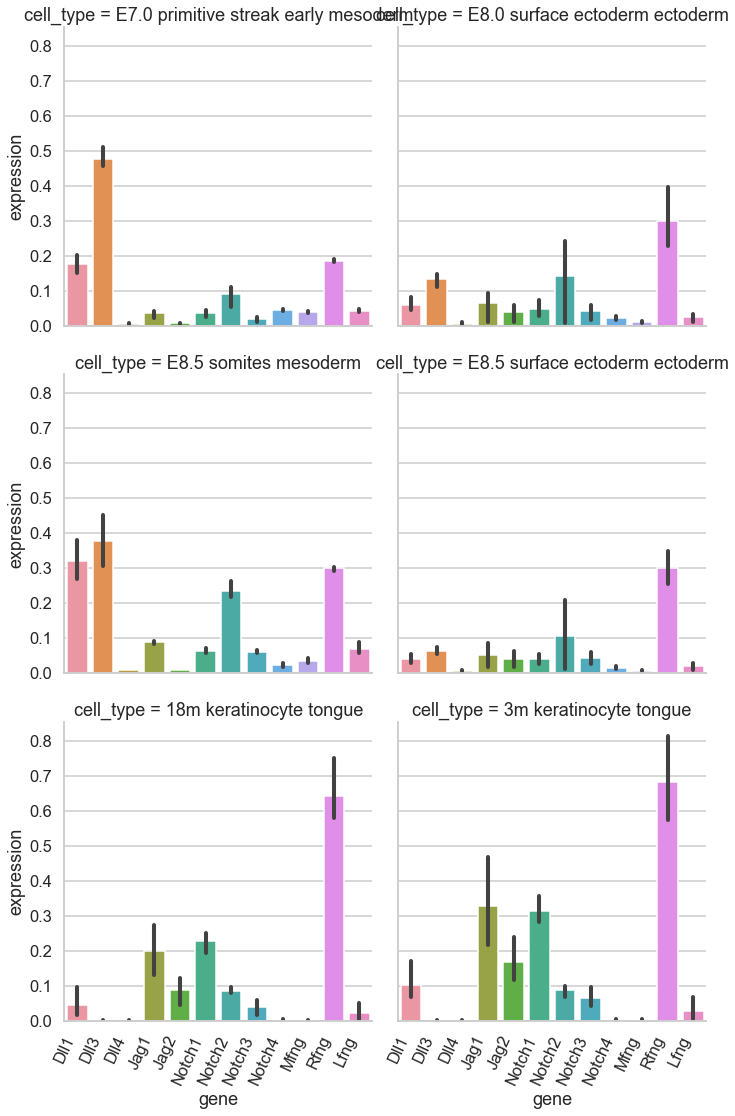

In [43]:
sns.set_style("whitegrid",{"xtick.major.size": 12, "ytick.major.size": 12})
sns.set_context("talk")


cell_type = scaled_tidy.loc[scaled_tidy.cell_type.isin(which_cell_types),:]
chart = sns.catplot(data = cell_type, x = 'gene', y ='expression',
                       kind ='bar', legend =True, col = 'cell_type',
                   col_wrap = 2)

chart.set_xticklabels(rotation=65, horizontalalignment='right')


C:\Users\bacte\anaconda3\envs\torch\lib\site-packages\seaborn\matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


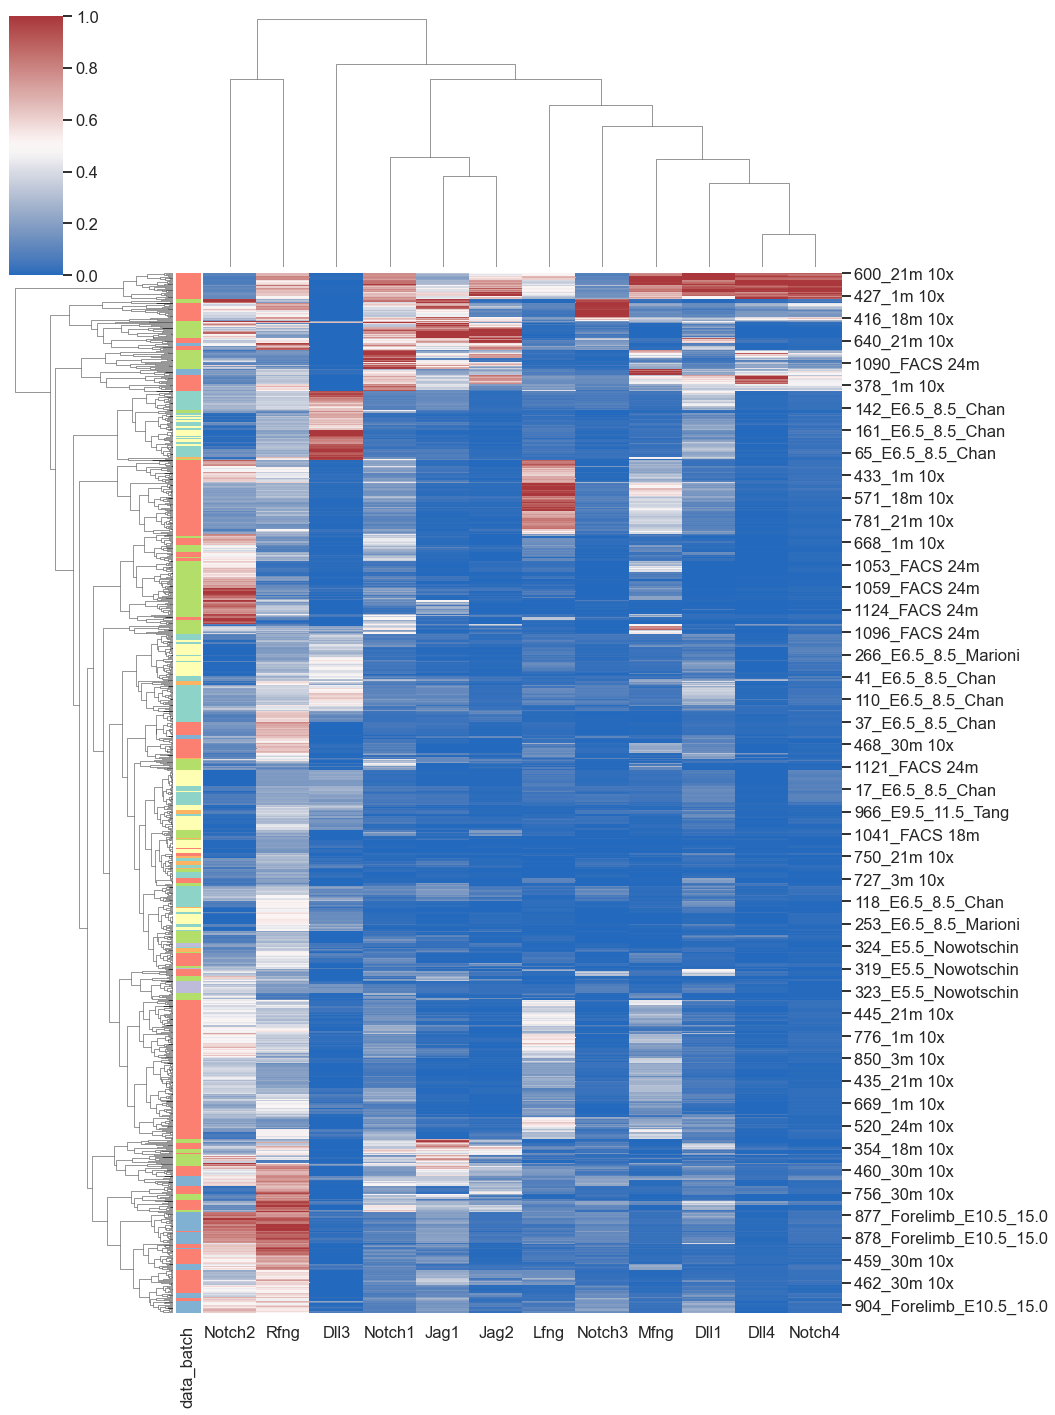

In [57]:
x = normalized_gene_expression[genes_pathway]

x = np.log1p(x.values)
annotatedHeatmap(x, gene_list = genes_pathway, ann_var ='data_batch')

# Latent space 


In [45]:
latent = vae.get_latent_representation() 

adata.obsm['X_scVI'] = latent

In [78]:
adata.layers['scvi_normalized'] =vae.get_normalized_expression(library_size = 10e4)

WARNING  Make sure the registered X field in anndata contains unnormalized count data.       


In [73]:
sc.pp.log1p(adata)

In [79]:
sc.pp.neighbors(adata, use_rep ='X_scVI',n_neighbors=15)
sc.tl.umap(adata,min_dist = 0.2)

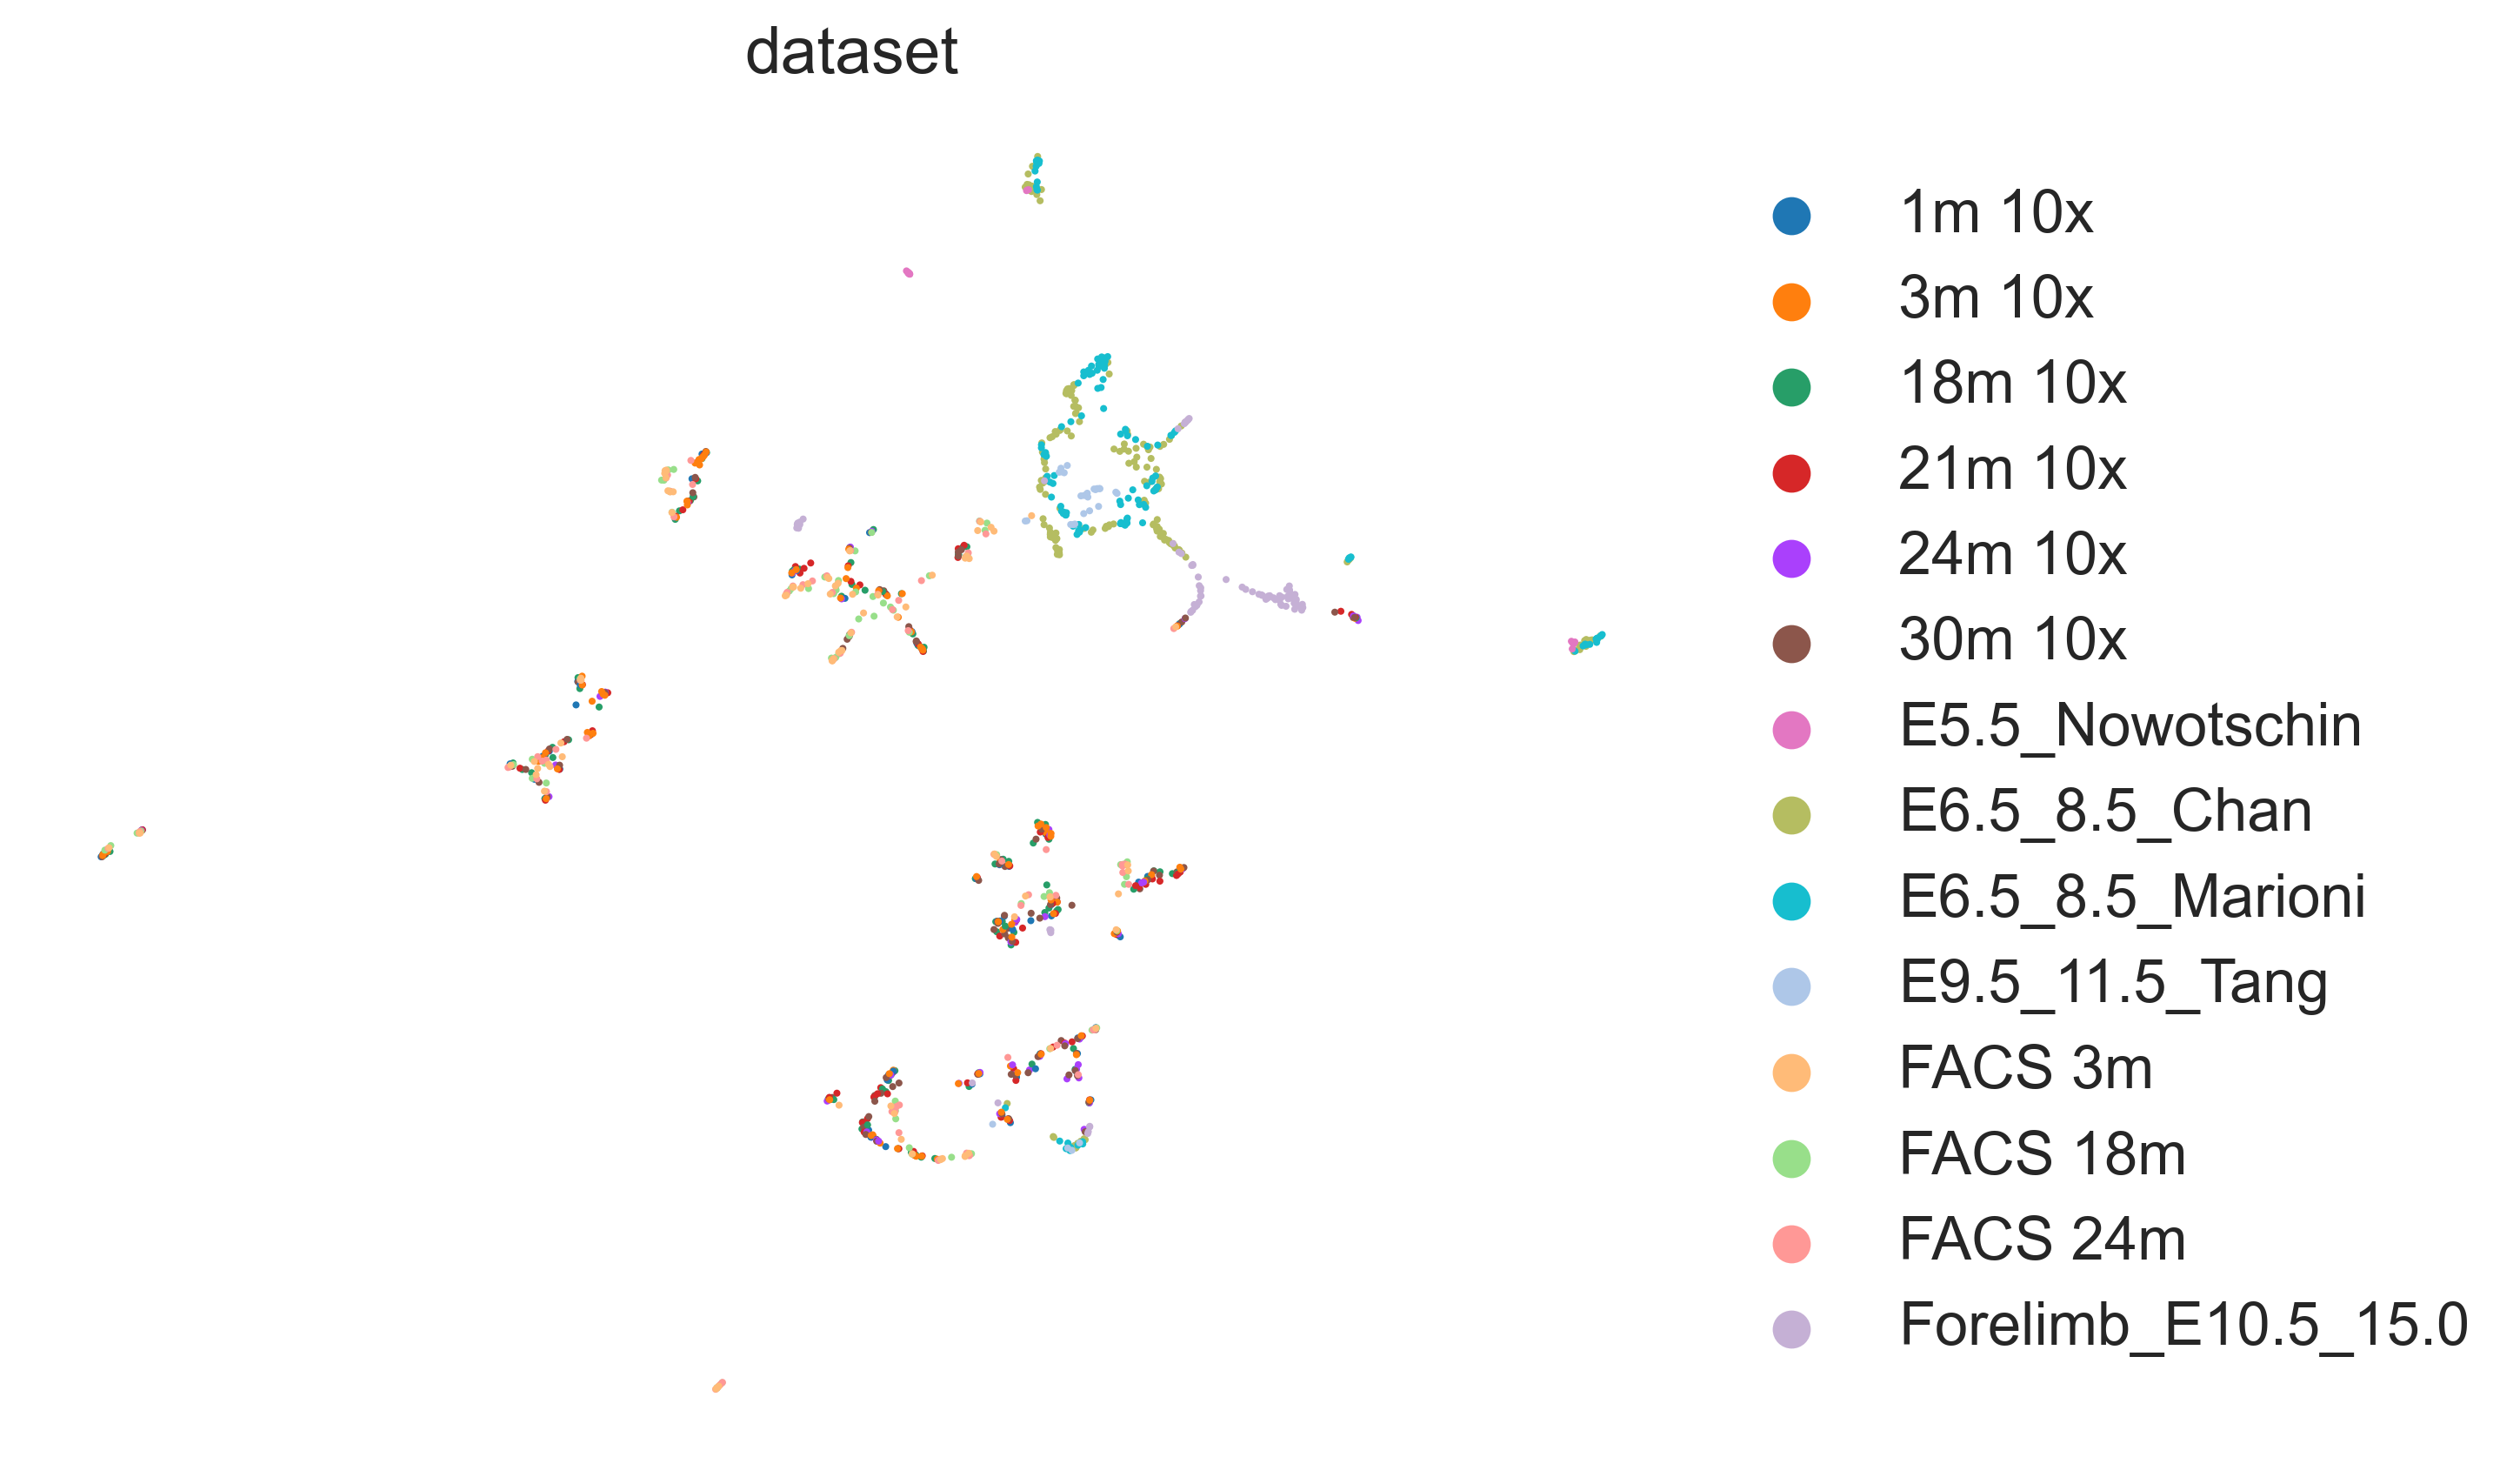

In [80]:
fig =  plt.figure(figsize = (10,6), tight_layout =True, dpi = 300)
ax = fig.add_subplot(1, 1, 1)

sc.pl.umap(
    adata,
    color=["dataset"],
    frameon=False,
    save='global_umap_latent_dataset.png',
    size = 15, 
    ax = ax
)

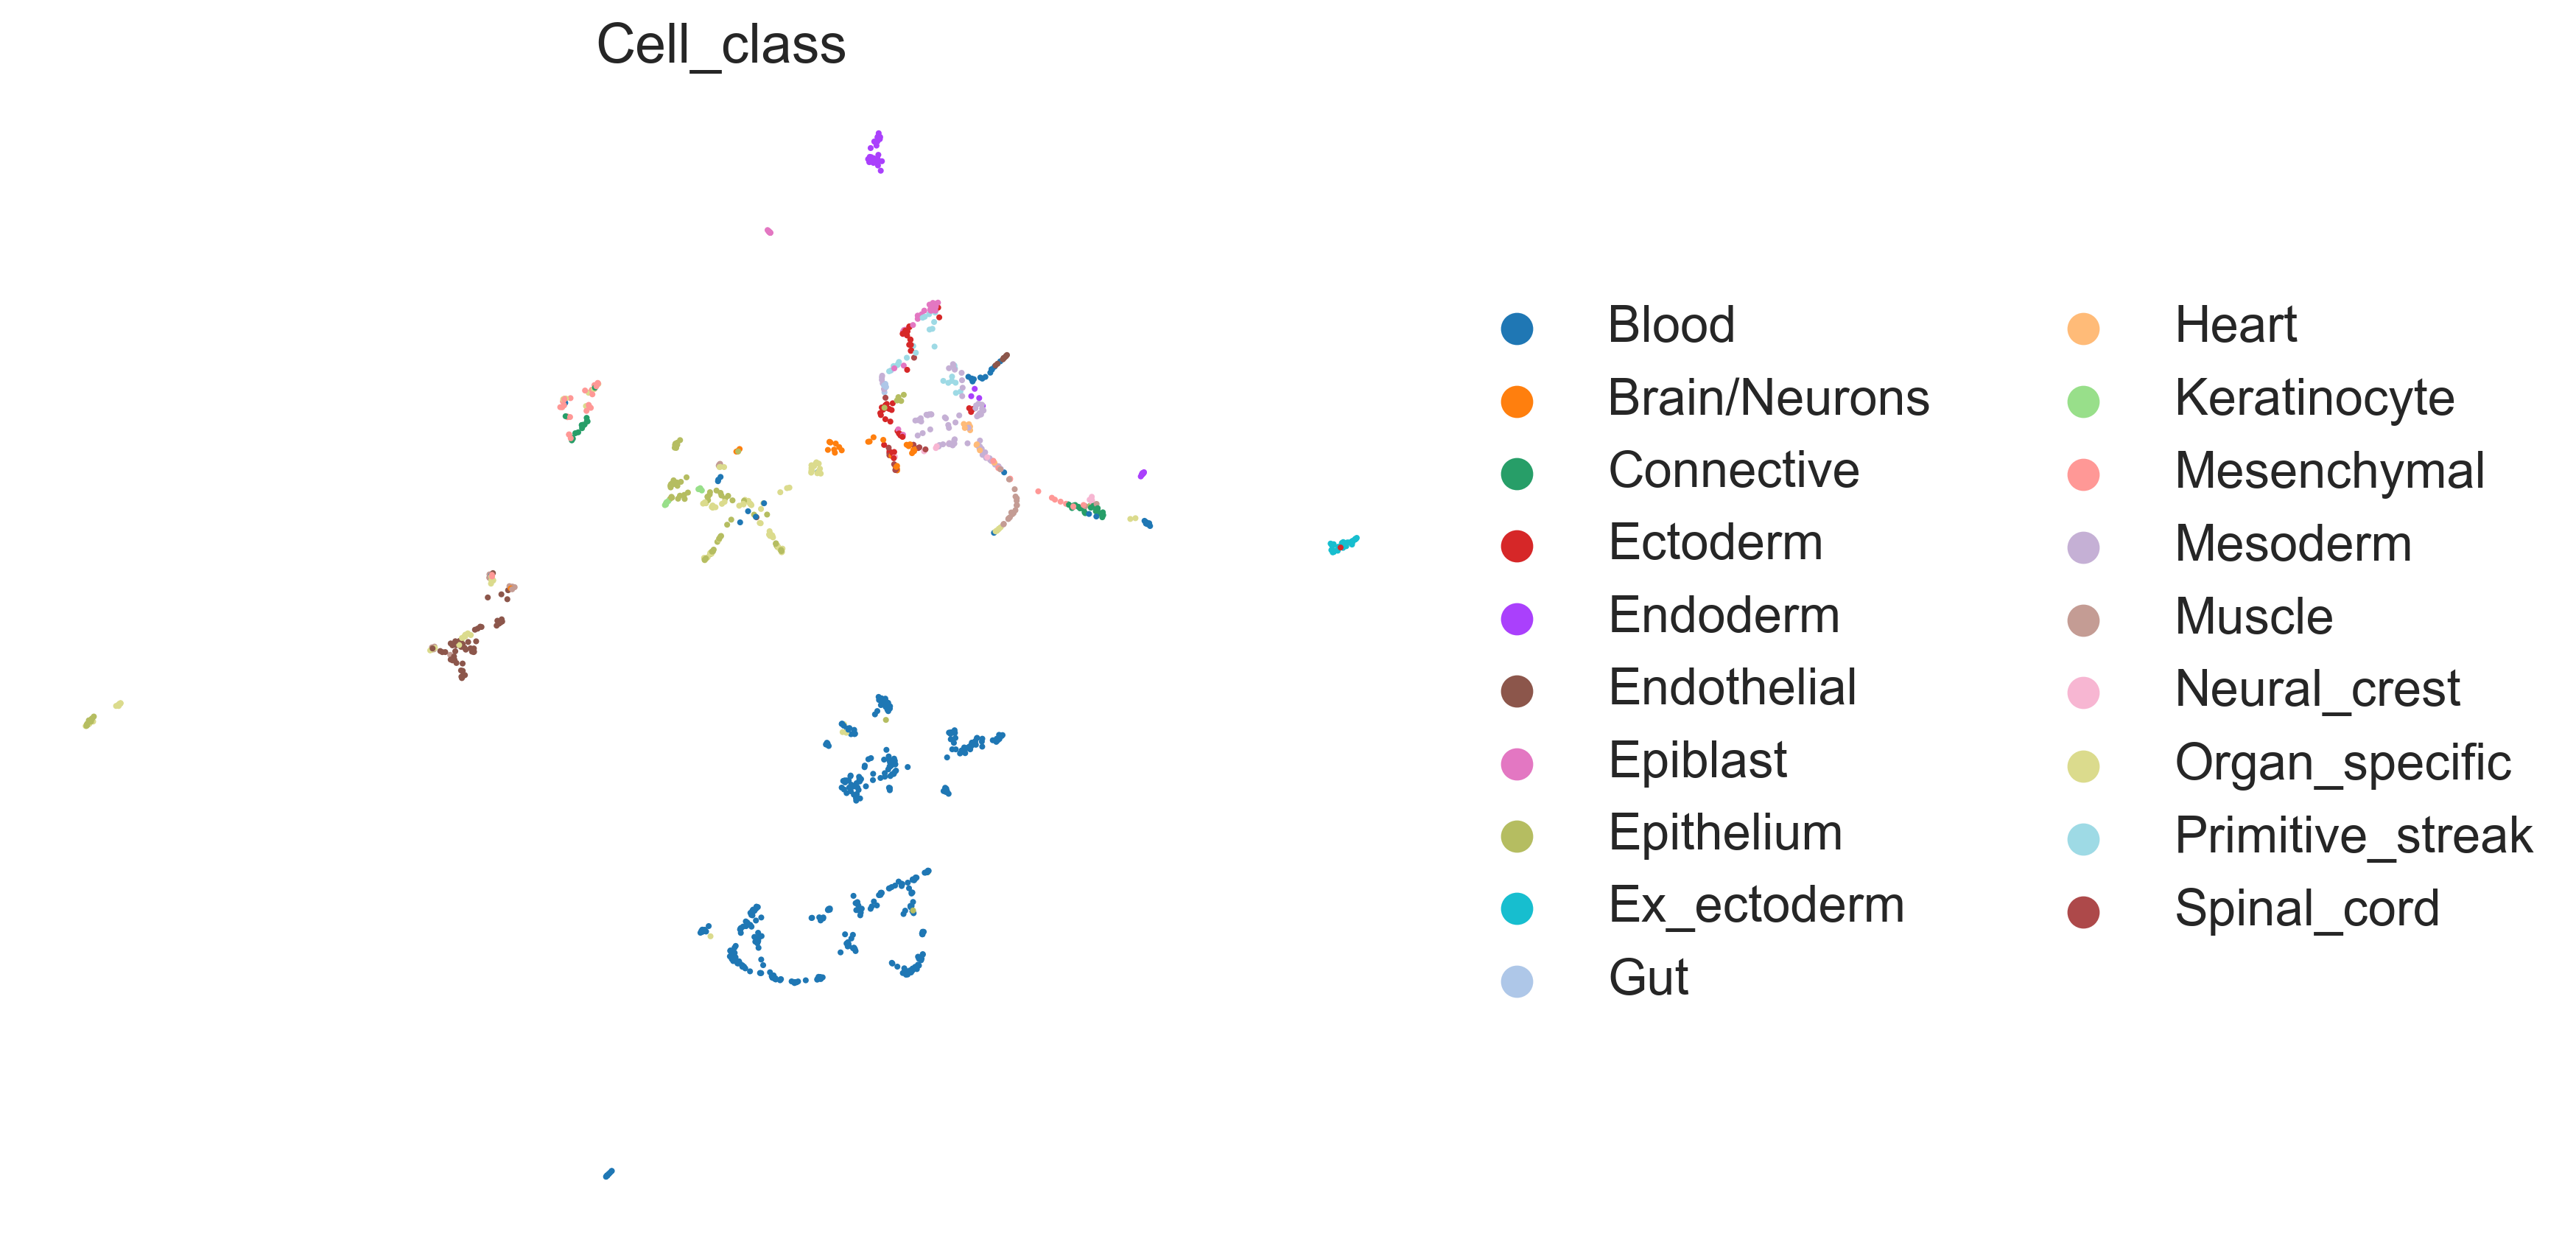

In [55]:

fig =  plt.figure(figsize = (12,6), tight_layout =True, dpi = 300)
ax = fig.add_subplot(1, 1, 1)

sc.pl.umap(
    adata,
    color=["Cell_class"],
    frameon=False,
    save='global_umap_latent_dataset.png',
    size = 15, 
    ax = ax
)



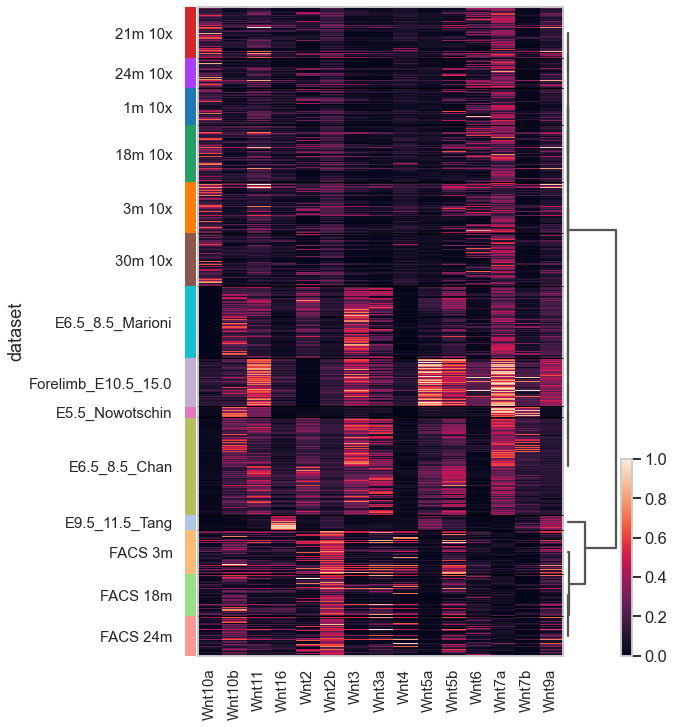

In [81]:

sc.pl.heatmap(
    adata,
    genes_pathway,
    groupby='dataset',
    layer="scvi_normalized",
    standard_scale='var',
    dendrogram=True,
    figsize = (8,12)
)

In [ ]:
normalized_gene_expression.to_csv('')